In [1]:
num_epoch = 500      
learning_rate = 0.01
batch_size = 2000

hidden_size = 32 #number of features in hidden state
num_layers = 4  #number of stacked lstm layers
bidirectional = True
drop_out = 0
bidirectional_forward_backward = 2 if bidirectional else 1

input_size = 41 #number of features
num_classes_attack_cat = 10 #number of output classes 
num_classes_label = 2       #number of output classes 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data.dataset import Dataset
from torch.utils.data import random_split, DataLoader
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from torch.autograd import Variable 

# GPU OR CPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")

GPU


In [4]:
class DataSet_UNSWNB15_attack_cat(Dataset):

    def __init__(self,data_set_path):
        df = pd.read_csv(data_set_path)
        print(df.attack_cat.value_counts().sort_values().plot(kind = "barh"))
        
        # preprocceing
        df.drop(['id',"Unnamed: 0","service","label"], axis=1, inplace=True)        
        cols = ['attack_cat' ,'proto' ,'state']
        df[cols] = df[cols].apply(LabelEncoder().fit_transform)

        self.data_array = df.values
        self.x = self.data_array[:, :41]
        self.y = self.data_array[:, 41]
      
        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample

        
class DataSet_UNSWNB15_label(Dataset):

    def __init__(self,data_set_path):
        df = pd.read_csv(data_set_path)
        print(df.label.value_counts().sort_values().plot(kind = "pie"))

        # preprocceing
        df.drop(['id',"Unnamed: 0","service","attack_cat"], axis=1, inplace=True)
        cols = ['proto' ,'state']
        df[cols] = df[cols].apply(LabelEncoder().fit_transform)

        self.data_array = df.values
        self.x = self.data_array[:, :41]
        self.y = self.data_array[:, 41]
        
        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample

AxesSubplot(0.125,0.125;0.775x0.755)


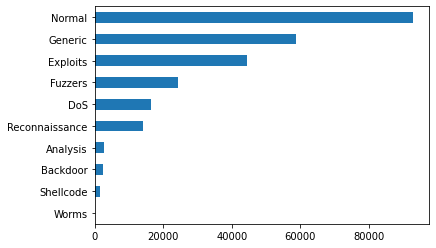

In [5]:
dataset_attack_cat = DataSet_UNSWNB15_attack_cat("/content/drive/MyDrive/datasets/UNSW-NB15/UNSW_NB15.csv")
number_of_test = int(len(dataset_attack_cat)*0.3)
number_of_train = len(dataset_attack_cat) - int(len(dataset_attack_cat)*0.3)
train_attack_cat ,test_attack_cat = random_split(dataset=dataset_attack_cat, lengths=[number_of_train,number_of_test])

train_attack_cat_dataloader = DataLoader(dataset=train_attack_cat ,batch_size=batch_size ,shuffle=True)
test_attack_cat_dataloader = DataLoader(dataset=test_attack_cat ,batch_size=batch_size ,shuffle=True)

AxesSubplot(0.260833,0.125;0.503333x0.755)


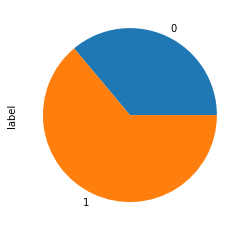

In [6]:
dataset_label = DataSet_UNSWNB15_label("/content/drive/MyDrive/datasets/UNSW-NB15/UNSW_NB15.csv")
number_of_test = int(len(dataset_label)*0.3)
number_of_train = len(dataset_label) - int(len(dataset_label)*0.3)
train_label ,test_label = random_split(dataset=dataset_label, lengths=[number_of_train,number_of_test])

train_label_dataloader = DataLoader(dataset=train_label ,batch_size=batch_size ,shuffle=True)
test_label_dataloader = DataLoader(dataset=test_label ,batch_size=batch_size ,shuffle=True)

# **preprocessing ended**

# **create model**

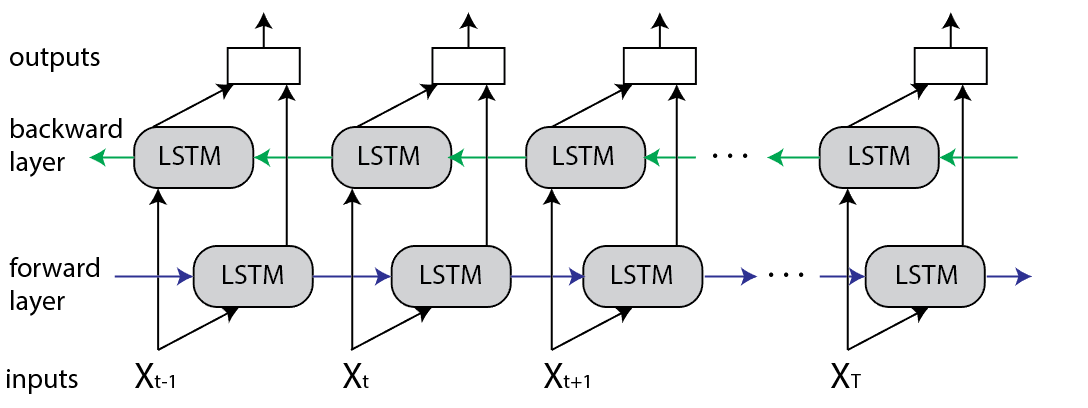

In [7]:
class LSTM_Model_attack(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM_Model_attack, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True,
                            bidirectional=bidirectional, dropout=drop_out) #lstm

        self.fc = nn.Linear(hidden_size * bidirectional_forward_backward, num_classes) #fully connected last layer
                             # 2 => forward and backward for bidirectional
    
    def forward(self,x):
                                                # 2 => forward and backward for bidirectional
        h_0 = Variable(torch.zeros(self.num_layers * bidirectional_forward_backward, x.size(0), self.hidden_size)).to(device=device) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers * bidirectional_forward_backward, x.size(0), self.hidden_size)).to(device=device) #internal state

        out, (hn, cn) = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :]) 
        return out


class LSTM_Model_label(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM_Model_label, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, 
                            bidirectional=bidirectional, dropout=drop_out) #lstm

        self.fc = nn.Linear(hidden_size * bidirectional_forward_backward, num_classes) #fully connected last layer

    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers * bidirectional_forward_backward, x.size(0), self.hidden_size)).to(device=device) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers * bidirectional_forward_backward, x.size(0), self.hidden_size)).to(device=device) #internal state

        out, (hn, cn) = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :]) 
        return out


In [8]:
my_model_attack = LSTM_Model_attack(num_classes_attack_cat, input_size, hidden_size, num_layers).to(device=device)
my_model_attack

LSTM_Model_attack(
  (lstm): LSTM(41, 32, num_layers=4, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=64, out_features=10, bias=True)
)

In [9]:
my_model_attack.state_dict()

OrderedDict([('lstm.weight_ih_l0',
              tensor([[ 0.0919,  0.1115,  0.1276,  ..., -0.0483, -0.0422,  0.0305],
                      [-0.0696,  0.1043,  0.1700,  ...,  0.1396, -0.0333,  0.0415],
                      [ 0.1627, -0.1101,  0.1589,  ...,  0.1036,  0.1640,  0.0849],
                      ...,
                      [ 0.0605, -0.1458,  0.1159,  ...,  0.0998, -0.0113,  0.0512],
                      [ 0.0129, -0.0277,  0.1283,  ..., -0.0114, -0.0834,  0.0268],
                      [-0.1203,  0.1572, -0.1220,  ..., -0.1587,  0.1558,  0.0272]],
                     device='cuda:0')),
             ('lstm.weight_hh_l0',
              tensor([[ 0.0055, -0.1121, -0.0857,  ...,  0.0081, -0.0438,  0.0602],
                      [-0.1752,  0.0528,  0.0317,  ...,  0.1290, -0.0957, -0.1392],
                      [-0.1660, -0.1635,  0.1518,  ..., -0.0341,  0.0266, -0.0547],
                      ...,
                      [ 0.1390,  0.0429, -0.0177,  ..., -0.0267,  0.0306,  0.08

In [10]:
my_model_label = LSTM_Model_label(num_classes_label, input_size, hidden_size, num_layers).to(device=device)
my_model_label

LSTM_Model_label(
  (lstm): LSTM(41, 32, num_layers=4, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

# **optimizer and loss function**

In [11]:
loss_fn1 = nn.CrossEntropyLoss().to(device=device)
loss_fn2 = nn.CrossEntropyLoss().to(device=device)
optimizer1 = opt.Adam(params=my_model_attack.parameters(),lr=learning_rate)
optimizer2 = opt.Adam(params=my_model_label.parameters(),lr=learning_rate)

# **train attack cat**

In [12]:
for epoch in range(num_epoch+1):

    for batch_x, batch_y in train_attack_cat_dataloader:

        batch_x = torch.reshape(batch_x, (batch_x.shape[0], 1, batch_x.shape[1])) #RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors
        
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer1.zero_grad()
        loss1 = loss_fn1(my_model_attack(batch_x) , batch_y)
        loss1.backward() 
        optimizer1.step()

    if epoch % 50 == 0:
         print("Epoch: %d, loss: %.4f" % (epoch, loss1.item())) 

Epoch: 0, loss: 0.6598
Epoch: 50, loss: 0.4290
Epoch: 100, loss: 0.4563
Epoch: 150, loss: 0.3714
Epoch: 200, loss: 0.3550
Epoch: 250, loss: 0.3370
Epoch: 300, loss: 0.2923
Epoch: 350, loss: 0.2935
Epoch: 400, loss: 0.3302
Epoch: 450, loss: 0.3877
Epoch: 500, loss: 0.3183


# **test attack cat**

In [13]:
correct = 0

for batch_x, labl in test_attack_cat_dataloader:
  
    batch_x = torch.reshape(batch_x, (batch_x.shape[0], 1, batch_x.shape[1])) #RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors
  
    batch_x = batch_x.to(device)
    labl = labl.to(device)

    out = my_model_attack(batch_x)
    _,predicted = torch.max(out,1)
    correct += torch.sum(predicted == labl)

print("acc : %.2f" % (100.*correct / len(test_attack_cat)),end="")
print("%")

acc : 81.09%


# **train label**

In [14]:
for epoch in range(num_epoch+1):

    for batch_x, batch_y in train_label_dataloader:

        batch_x = torch.reshape(batch_x, (batch_x.shape[0], 1, batch_x.shape[1])) #RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors
        
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer2.zero_grad()
        loss2 = loss_fn2(my_model_label(batch_x) , batch_y)
        loss2.backward() 
        optimizer2.step()

    if epoch % 50 == 0:
         print("Epoch: %d, loss: %.4f" % (epoch, loss2.item())) 

Epoch: 0, loss: 0.1684
Epoch: 50, loss: 0.1036
Epoch: 100, loss: 0.0657
Epoch: 150, loss: 0.0661
Epoch: 200, loss: 0.0727
Epoch: 250, loss: 0.0527
Epoch: 300, loss: 0.0670
Epoch: 350, loss: 0.0426
Epoch: 400, loss: 0.0879
Epoch: 450, loss: 0.0419
Epoch: 500, loss: 0.0564


# **test label**

In [15]:
correct = 0

for batch_x, labl in test_label_dataloader:

    batch_x = torch.reshape(batch_x, (batch_x.shape[0], 1, batch_x.shape[1])) #RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors

    batch_x = batch_x.to(device)
    labl = labl.to(device)
  
    out = my_model_label(batch_x)
    _,predicted = torch.max(out,1)
    correct += torch.sum(predicted == labl)

print("acc : %.2f" % (100.*correct / len(test_label)),end="")
print("%")

acc : 93.22%
